In [ ]:
# Import PyTorch
import torch
from torch import nn

# Import torchvision
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

# Import matplotlib for visualization
import matplotlib.pyplot as plt

# Check version
print(f"PyTorch version: {torch.__version__}\ntorchvision version: {torchvision.__version__}")

# Device agnostic
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device: {device}")


PyTorch version: 2.0.1+cu118
torchvision version: 0.15.2+cu118
Device: cuda


In [ ]:
train_data = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None
)
test_data = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

100%|██████████| 170498071/170498071 [00:01<00:00, 93829125.10it/s] 


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


images shape: torch.Size([3, 32, 32]), label shape: 6
Train data length: 50000, Train targets length: 50000
Test data length: 10000, Test targets length: 10000
Class names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Text(0.5, 1.0, 'frog')

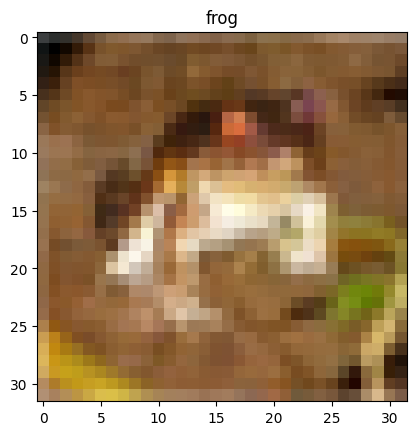

In [ ]:
image, label = train_data[0]
print(f"images shape: {image.shape}, label shape: {label}")
print(f"Train data length: {len(train_data.data)}, Train targets length: {len(train_data.targets)}")
print(f"Test data length: {len(test_data.data)}, Test targets length: {len(test_data.targets)}")
class_names = train_data.classes
print(f"Class names: {class_names}")
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])

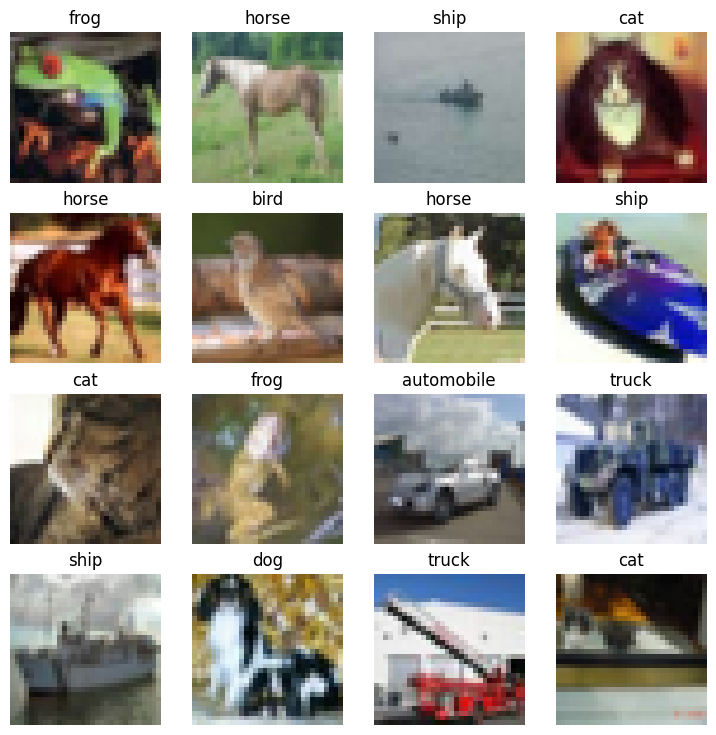

In [ ]:
# Plot more images
torch.manual_seed(42)
fig = plt.figure(figsize=(9,9))
rows, cols = 4, 4
for i in range(1, rows * cols +1):
  random_idx = torch.randint(0, len(train_data), size=[1]).item()
  img, label = train_data[random_idx]
  fig.add_subplot(rows, cols, i)
  plt.imshow(img.permute(1,2,0))
  plt.title(class_names[label])
  plt.axis(False);

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x7fcd73cf4880>, <torch.utils.data.dataloader.DataLoader object at 0x7fcd73cf7460>)
Length of train dataloader: 1563 batches of 32
Length of test dataloader: 313 batches of 32
Features batch shape: torch.Size([32, 3, 32, 32]), Labels batch shape: torch.Size([32])
Image size: torch.Size([3, 32, 32])
Label: 8, label size: torch.Size([])


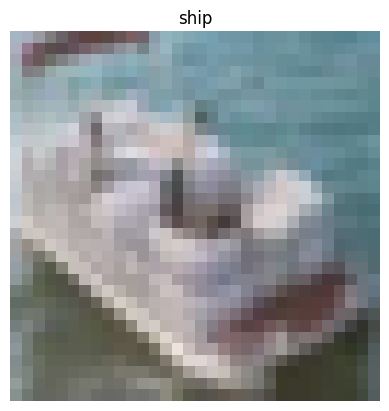

In [ ]:
from torch.utils.data import DataLoader

# Setup the batch size
BATCH_SIZE = 32

# Turn datasets into iterables (batches)
train_dataloader = DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    shuffle=True
)
test_dataloader = DataLoader(
    test_data,
    batch_size=BATCH_SIZE,
    shuffle=False
)

# Check dataloade lengths
print(f"Dataloaders: {train_dataloader, test_dataloader}")
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

# Check out what's inside the training dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))
print(f"Features batch shape: {train_features_batch.shape}, Labels batch shape: {train_labels_batch.shape}")

# Show a sample
torch.manual_seed(42)
random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.imshow(img.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False);
print(f"Image size: {img.shape}")
print(f"Label: {label}, label size: {label.shape}")

In [ ]:
class VGG(nn.Module):
  def __init__(self, in_shape: int, hidden_units: int, out_shape: int):
    super().__init__()
    self.block1 = nn.Sequential(
        nn.Conv2d(
            in_channels=in_shape,
            out_channels=hidden_units,
            kernel_size=3,
            stride=1,
            padding=1
        ),
        nn.ReLU(),
        nn.Conv2d(
            in_channels=hidden_units,
            out_channels=hidden_units*4,
            kernel_size=3,
            stride=1,
            padding=1
        ),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )
    self.block2 = nn.Sequential(
        nn.Conv2d(
            in_channels=hidden_units*4,
            out_channels=hidden_units*4,
            kernel_size=3,
            stride=1,
            padding=1
        ),
        nn.ReLU(),
        nn.Conv2d(
            in_channels=hidden_units*4,
            out_channels=hidden_units*8,
            kernel_size=3,
            stride=1,
            padding=1
        ),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )
    self.block3 = nn.Sequential(
        nn.Conv2d(
            in_channels=hidden_units*8,
            out_channels=hidden_units*8,
            kernel_size=3,
            stride=1,
            padding=1
        ),
        nn.ReLU(),
        nn.Conv2d(
            in_channels=hidden_units*8,
            out_channels=hidden_units,
            kernel_size=3,
            stride=1,
            padding=1
        ),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*4*4,
                  out_features=out_shape)
    )

  def forward(self, x: torch.Tensor):
    return self.classifier(self.block3(self.block2(self.block1(x))))

In [ ]:
torch.manual_seed(42)
model_0 = VGG(
    in_shape=3,
    hidden_units=10,
    out_shape=len(class_names)
)
print(model_0.to(device))
print(f"Model on Device: {next(model_0.parameters()).device}")

VGG(
  (block1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(40, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block3): Sequential(
    (0): Conv2d(80, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(80, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=160, out_feature

In [ ]:
x = torch.rand(size=(1,3,32,32))
x = model_0(x.to(device))

In [ ]:
import time
def train_time(start: float, end: float, device: torch.device=None):
  total_time = end - start
  print(f"Train time on {device}: {total_time:.3f} seconds")
  return total_time

In [ ]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device):
  # Setup loss/acc
  train_loss, train_acc = 0, 0
  # Send model to device
  model.to(device)
  # Set model to train mode
  model.train()
  for batch, (img, label) in enumerate(dataloader):
    # Send data to device
    img, label = img.to(device), label.to(device)

    # 1. Forward pass, make predictions
    pred = model(img)

    # 2. Calculate loss/acc
    loss = loss_fn(pred, label)
    train_loss += loss
    train_acc += (torch.eq(pred.softmax(dim=1).argmax(dim=1), label).sum().item()/len(label))*100

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

  # Calculate loss and accuracy per epoch
  train_loss /= len(dataloader)
  train_acc /= len(dataloader)
  print(f"Train loss: {train_loss:.4f} | Train accuracy: {train_acc:.2f}%")

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device):
  # Setup loss/acc
  test_loss, test_acc = 0, 0
  # Send model to device
  model.to(device)
  # Set model to eval mode and inference mode
  model.eval()
  with torch.inference_mode():
    for batch, (img, label) in enumerate(dataloader):
      # Send data to device
      img, label = img.to(device), label.to(device)

      # Make predictions
      pred = model(img)

      # Calculate loss/acc
      test_loss += loss_fn(pred, label)
      test_acc += (torch.eq(pred.softmax(dim=1).argmax(dim=1), label).sum().item()/len(label))*100

    # Calculate loss and accuracy per epoch
    test_loss /= len(dataloader)
    test_acc /= len(dataloader)
    print(f"Test loss: {test_loss:.4f} | Test accuracy: {test_acc:.2f}%")

In [ ]:
from tqdm.auto import tqdm
torch.manual_seed(42)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

epochs = 5

t_start = time.time()

for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n------")
  train_step(model=model_0,
             dataloader=train_dataloader,
             loss_fn=loss_fn,
             optimizer=optimizer,
             device=device)
  test_step(model=model_0,
            dataloader=test_dataloader,
            loss_fn=loss_fn,
            device=device)

train_time_model_0 = train_time(t_start, time.time(), device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0
------
Train loss: 2.3025 | Train accuracy: 10.35%
Test loss: 2.2687 | Test accuracy: 14.63%
Epoch: 1
------
Train loss: 1.8115 | Train accuracy: 33.83%
Test loss: 1.5425 | Test accuracy: 43.71%
Epoch: 2
------
Train loss: 1.4115 | Train accuracy: 48.85%
Test loss: 1.2235 | Test accuracy: 55.93%
Epoch: 3
------
Train loss: 1.1788 | Train accuracy: 57.95%
Test loss: 1.2446 | Test accuracy: 55.22%
Epoch: 4
------
Train loss: 1.0314 | Train accuracy: 63.55%
Test loss: 0.9507 | Test accuracy: 65.98%
Train time on cuda: 80.153 seconds


In [ ]:
### Eval model
torch.manual_seed(42)
def eval_model(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               device: torch.device):
  loss, acc = 0, 0
  model.to(device)
  model.eval()
  with torch.inference_mode():
    for batch, (img, label) in enumerate(dataloader):
      img, label = img.to(device), label.to(device)
      pred = model(img)
      loss += loss_fn(pred, label)
      acc += (torch.eq(pred.softmax(dim=1).argmax(dim=1), label).sum().item()/len(label))*100

    loss /= len(dataloader)
    acc /= len(dataloader)

  return {"model_name": model.__class__.__name__,
          "model_loss": loss.item(),
          "model_acc": acc}

In [ ]:
model_0_results = eval_model(model=model_0,
                             dataloader=test_dataloader,
                             loss_fn=loss_fn,
                             device=device)
print(f"\nModel0 results: {model_0_results}")


Model0 results: {'model_name': 'VGG', 'model_loss': 0.9507397413253784, 'model_acc': 65.9844249201278}


In [ ]:
def make_predictions(model: torch.nn.Module,
                     data: list,
                     device: torch.device):
  pred_probs = []
  model.eval()
  with torch.inference_mode():
    for sample in data:
      sample = sample.unsqueeze(0).to(device)

      pred_logit = model(sample)

      pred_prob = pred_logit.squeeze().softmax(dim=0)

      pred_probs.append(pred_prob.cpu())

  return torch.stack(pred_probs)

In [ ]:
import random
random.seed(42)
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
  test_samples.append(sample)
  test_labels.append(label)

pred_probs = make_predictions(model=model_0,
                             data=test_samples,
                             device=device)

pred_classes = pred_probs.argmax(dim=1)

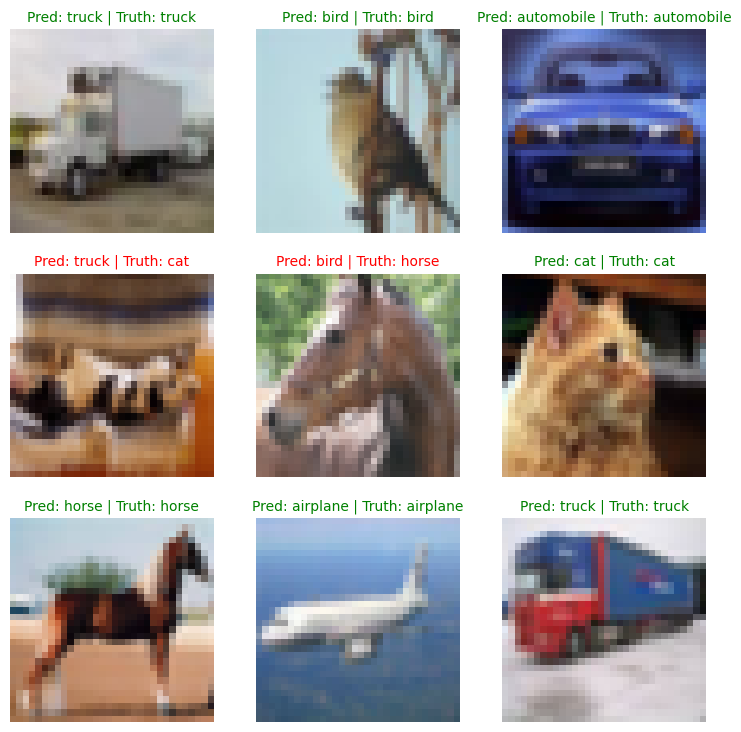

In [ ]:
plt.figure(figsize=(9,9))
nrows, ncols = 3, 3
for i, sample in enumerate(test_samples):
  plt.subplot(nrows, ncols, i+1)

  plt.imshow(sample.permute(1,2,0))

  pred_label = class_names[pred_classes[i]]
  truth_label = class_names[test_labels[i]]

  title_text = f"Pred: {pred_label} | Truth: {truth_label}"

  if pred_label == truth_label:
    plt.title(title_text, fontsize=10, c='g')
  else:
    plt.title(title_text, fontsize=10, c='r')
  plt.axis(False);